In [8]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(1024, 512, 3)


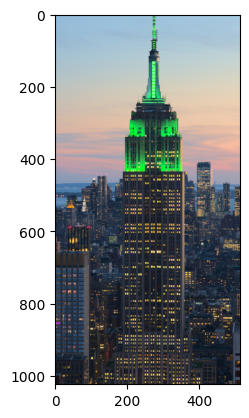

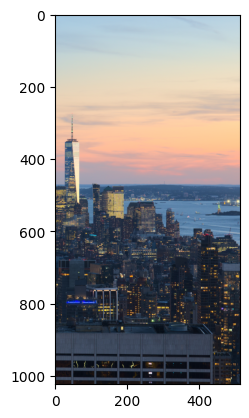

In [18]:
image = io.imread("data/EmpireState.jpg")[500:4596, 3000:5048, 0:3]
image = transform.resize(image, (image.shape[0] / 4, image.shape[1] / 4), anti_aliasing=True)

val_image = io.imread("data/EmpireState.jpg")[500:4596, 5048:5048+2048, 0:3]
val_image = transform.resize(val_image, (val_image.shape[0] / 4, val_image.shape[1] / 4), anti_aliasing=True)
print(image.shape)
plt.imshow(image)
plt.show()
plt.imshow(val_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 512, 1024])
torch.Size([3, 512, 1024])


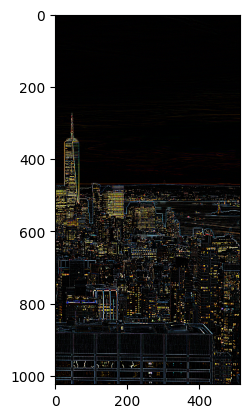

In [28]:
import torch.nn.functional as f
downscale_factor = .25
device = "cuda"
gpu_image = torch.from_numpy(image).to(device)
gpu_image = torch.swapaxes(gpu_image, 0, 2).float()

val_gpu_image = torch.from_numpy(val_image).to(device)
val_gpu_image = torch.swapaxes(val_gpu_image, 0, 2).float()

down_image = f.interpolate(gpu_image.unsqueeze(0), (256, 512), mode="bilinear").squeeze(0)
up_image = f.interpolate(down_image.unsqueeze(0), (512, 1024), mode="bilinear").squeeze(0)

val_down_image = f.interpolate(val_gpu_image.unsqueeze(0), (256, 512), mode="bilinear").squeeze(0)
val_up_image = f.interpolate(val_down_image.unsqueeze(0), (512, 1024), mode="bilinear").squeeze(0)

print(gpu_image.shape)
print(up_image.shape)

target = (gpu_image - up_image)*10

val_target = (val_gpu_image - val_up_image) * 10

cpu_image = val_target.cpu()
plt.imshow(cpu_image.swapaxes(0, 2))

In [59]:
from networks.overfit_network import OverfitNN
from torch.optim import SGD
from torch.optim import Adam
from torch.nn import MSELoss
from torch.nn import L1Loss

hp={
    "n1" : 8,
    "n2" : 16,
    "n3" : 16,
    "u2" : 16,
    "u1" : 16,
    "interface" : 16,
    "nupscaler" : 32
}

model = OverfitNN(hp=hp)

model.to(device)

optimizer = Adam(model.parameters(), lr=4e-3)

loss_func = MSELoss()
#loss_func = L1Loss()
losses = []
val_losses = []

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_parameters = count_parameters(model)
print("Model has {} parameters".format(num_parameters))


Model has 15771 parameters


train:   0%|                                                               | 0/1000 [00:00<?, ?it/s]

train: 100%|███████████████████████████████████| 1000/1000 [00:13<00:00, 75.90it/s, loss=0.07557254]


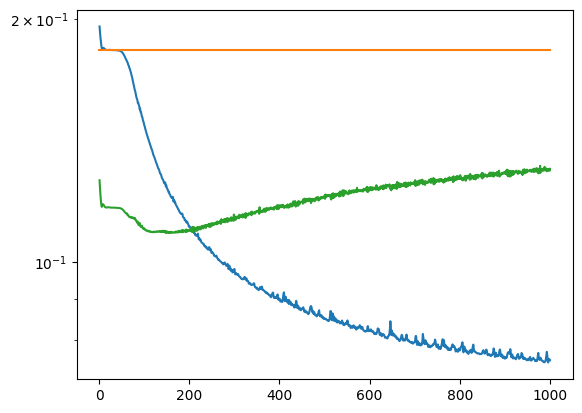

In [60]:
from tqdm import tqdm

iterations = 1000
bar = tqdm(range(iterations), total=iterations, desc="train", ncols=100)

#optimizer.lr=1e-3

for i in bar:
    model.train()
    model.zero_grad()
    prediction = model.forward(down_image)

    loss = loss_func(prediction, target)
    loss.backward()
    loss_value = loss.item()
    losses.append(loss_value)
    optimizer.step()
    bar.set_postfix(loss = "{:.8f}".format(loss_value))
    
    model.eval()
    prediction = model.forward(val_down_image)
    loss = loss_func(prediction, val_target)
    val_losses.append(loss.item())
    
black_loss = loss_func(torch.zeros(target.shape).to(device), target)
black_loss_value = black_loss.item()
plt.plot(np.linspace(1, len(losses), len(losses)), losses)
plt.plot((0, len(losses)), (black_loss_value, black_loss_value))
plt.plot(np.linspace(1, len(val_losses), len(val_losses)), val_losses)
plt.yscale("log")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

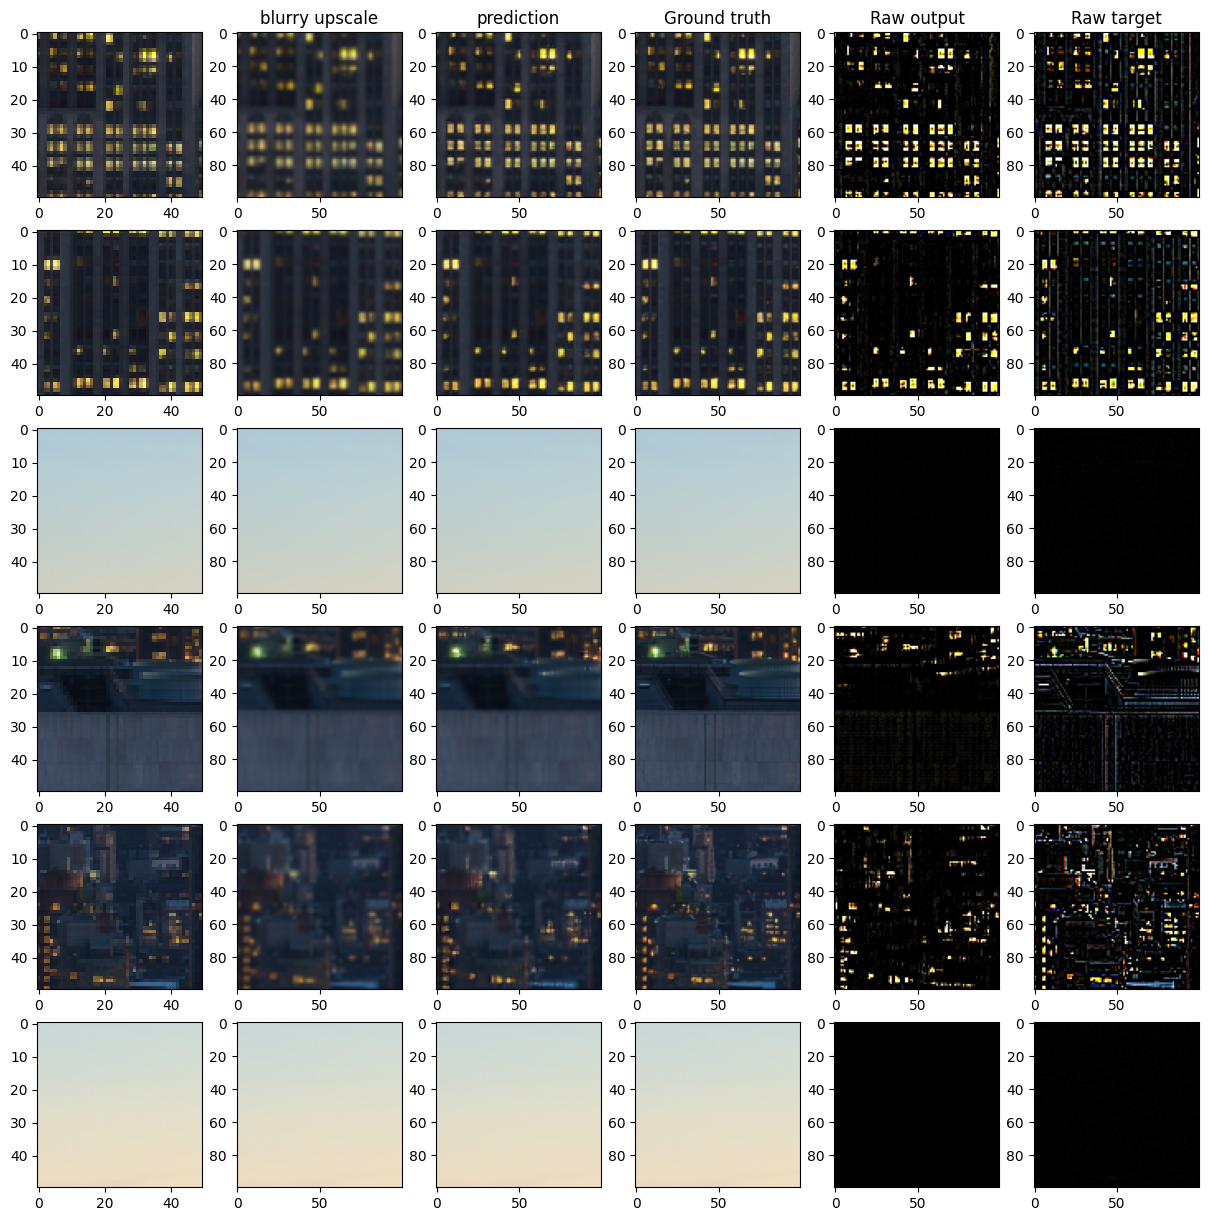

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


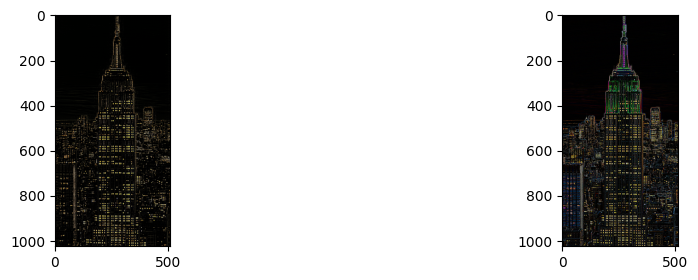

In [61]:
import random
import warnings
rows = 3
fig, axes = plt.subplots(rows * 2, 6, figsize=(12, 3))
fig.set_size_inches(15, 15)

prediction_unprocessed = model.forward(down_image).detach()
prediction = (model.forward(down_image) / 10 + up_image).detach()
target_cpu = target.cpu().swapaxes(0, 2)

val_prediction_unprocessed = model.forward(val_down_image).detach()
val_prediction = (model.forward(val_down_image) / 10 + val_up_image).detach()

def area_half_size(area, scale = 2):
    u, v, w, x = area
    return (int(u / scale), int(v / scale), int(w / scale), int(x / scale))

def random_image_slice(image, size=100):
    first = random.randint(0, image.shape[0] - size)  # Generate a random integer for the first number
    second = first + size  # Calculate the second number based on the offset
    third = random.randint(0, image.shape[1] - size)  # Generate a random integer for the third number
    fourth = third + size  # Calculate the fourth number based on the offset
    return (first, second, third, fourth)

def crop(image, area):
    return image[area[0]:area[1], area[2]:area[3], :]

def crop_gpu(image, area):
    return image[:, area[2]:area[3], area[0]:area[1]]

warnings.simplefilter("ignore", category=UserWarning)
for i in range(rows):
    area = random_image_slice(image)
    area_l = area_half_size(area)
    
    image1 = crop_gpu(down_image, area_l).cpu().swapaxes(0, 2)
    image2 = crop_gpu(up_image, area).cpu().swapaxes(0, 2)
    image3 = crop_gpu(prediction, area).cpu().swapaxes(0, 2)
    image4 = crop(image, area)
    image5 = crop_gpu(prediction_unprocessed, area).cpu().swapaxes(0, 2)
    image6 = crop_gpu(target, area).cpu().swapaxes(0, 2)
    
    axes[i, 0].imshow(image1)
    axes[0, 0].set_title('')

    axes[i, 1].imshow(image2)
    axes[0, 1].set_title('blurry upscale')

    axes[i, 2].imshow(image3)
    axes[0, 2].set_title('prediction')

    axes[i, 3].imshow(image4)
    axes[0, 3].set_title('Ground truth')

    axes[i, 4].imshow(image5)
    axes[0, 4].set_title('Raw output')

    axes[i, 5].imshow(image6)
    axes[0, 5].set_title('Raw target')
    
    image1 = crop_gpu(val_down_image, area_l).cpu().swapaxes(0, 2)
    image2 = crop_gpu(val_up_image, area).cpu().swapaxes(0, 2)
    image3 = crop_gpu(val_prediction, area).cpu().swapaxes(0, 2)
    image4 = crop(val_image, area)
    image5 = crop_gpu(val_prediction_unprocessed, area).cpu().swapaxes(0, 2)
    image6 = crop_gpu(val_target, area).cpu().swapaxes(0, 2)
    
    axes[rows + i, 0].imshow(image1)
    axes[0, 0].set_title('')

    axes[rows + i, 1].imshow(image2)
    axes[0, 1].set_title('blurry upscale')

    axes[rows + i, 2].imshow(image3)
    axes[0, 2].set_title('prediction')

    axes[rows + i, 3].imshow(image4)
    axes[0, 3].set_title('Ground truth')

    axes[rows + i, 4].imshow(image5)
    axes[0, 4].set_title('Raw output')

    axes[rows + i, 5].imshow(image6)
    axes[0, 5].set_title('Raw target')


plt.show()

fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].imshow(prediction_unprocessed.cpu().swapaxes(0, 2))
axes[1].imshow(target.cpu().swapaxes(0, 2))


torch.Size([3, 512, 1024])
(1024, 512, 3)


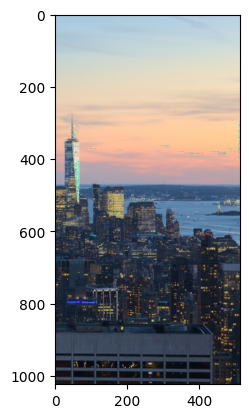

In [34]:
from PIL import Image


model.eval()
up = model.forward(val_down_image) / 10 + val_up_image


print(up.shape)
np_image = np.uint8(up.detach().swapaxes(0, 2).cpu().numpy() * 255)
print(np_image.shape)
pil_image = Image.fromarray(np_image)
plt.imshow(np_image)
pil_image.save("Empire_upscaled_from256.png")